In [1]:
import networkx as nx
import numpy as np

from mindquantum import Hamiltonian, QubitOperator, MQAnsatzOnlyLayer
from mindquantum import X, Z, RY, HardwareEfficientAnsatz
from mindquantum import Circuit, Simulator

from mindspore import nn, ops, Tensor
import mindspore as ms
ms.context.set_context(mode=ms.context.PYNATIVE_MODE, device_target="CPU")
import os
os.environ["OMP_NUM_THREADS"] = "4"


In [2]:
def gene_graph(num_nodes, p=0.3):
    """
    生成n个顶点的图, 两条边连接的概率是p, 默认为0.3
    """
    g = nx.Graph()
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if np.random.random() < p:
                nx.add_path(g, [i, j])
    return g
    
    
def get_max_cut(g):
    """
    输入图，输出max_cut结果
    """
    cut_size = 0
    power_set = [[]]
    for i in g.nodes:
        power_set = power_set+ [num + [i] for num in power_set if len(num) < int(len(g.nodes) / 2)]
    for subset in power_set:
        cut = nx.cut_size(g, subset)
        if cut > cut_size:
            cut_size = cut
    return cut_size


def gene_hams(g):
    """
    输入是图
    输出hams: list, 根据图的节点，返回所有的Z 和 X 测量
    如果是奇数qubit, 最后一个就不测量了
    """
    num_nodes = len(g.nodes)
    Z_nodes = int(np.ceil(num_nodes/2))
    X_nodes = num_nodes - Z_nodes
    hams = []
    for k in range(Z_nodes):
        hams.append(Hamiltonian(QubitOperator(f"Z{k}")))
    for k in range(Z_nodes):
        hams.append(Hamiltonian(QubitOperator(f"X{k}")))
    # print("Z: ", Z_nodes, "X: ", X_nodes)
    return hams


def gene_ansatz(depth, num_qubits):
    """
    输入线路的深度（奇数）与qubits数量
    输出fig2中的circuit
    """
    ansatz = Circuit()
    for layer in range(depth // 2):
        for i in range(num_qubits):
            ansatz += RY(f'{layer}{i}').on(i)
        if layer % 2 == 0:
            for i in range(0, num_qubits, 2):
                if i+1 < num_qubits:
                    ansatz += Z.on(i, i+1)
        else:
            for i in range(1, num_qubits, 2):
                if i+1 < num_qubits:
                    ansatz += Z.on(i, i+1)
        ansatz.barrier(False)
    for i in range(num_qubits):
            ansatz += RY(f'{depth // 2}{i}').on(i)
    ansatz.as_ansatz()
    return ansatz


class MBELoss(nn.LossBase):
    
    def __init__(self, g):
        """每一个图的loss不一样, 初始化时输入图g"""
        super(MBELoss, self).__init__()
        self.tanh = ops.Tanh()
        self.addn = ops.AddN()
        self.edges = g.edges

    def construct(self, logits):
        x = self.tanh(logits)
        loss_item = []
        for v1, v2 in self.edges:
            loss_item.append(x[v1]*x[v2])
        loss = self.addn(loss_item)

        return self.get_loss(loss)


class ForwardWithLoss(nn.Cell):
    """定义损失网络"""

    def __init__(self, backbone, loss_fn):
        """实例化时传入前向网络和损失函数作为参数"""
        super(ForwardWithLoss, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.loss_fn = loss_fn

    def construct(self, *inputs):
        """连接前向网络和损失函数"""
        logits = self.backbone(*inputs)
        return self.loss_fn(logits)

    def backbone_network(self):
        """要封装的骨干网络"""
        return self.backbone


class TrainOneStep(nn.TrainOneStepCell):
    """定义训练流程"""

    def __init__(self, network, optimizer):
        """参数初始化"""
        super(TrainOneStep, self).__init__(network, optimizer)
        self.grad = ops.GradOperation(get_by_list=True)

    def construct(self, *inputs):
        """构建训练过程"""
        weights = self.weights
        loss = self.network(*inputs)
        grads = self.grad(self.network, weights)(*inputs)
        return loss, self.optimizer(grads)


def MBEMaxCut(logits, g):
    max_cut = 0
    binary_logits = []
    for e in logits:
        if e < 0: 
            binary_logits.append(-1)
        else:
            binary_logits.append(1)
    for v1, v2 in g.edges:
        max_cut += (1 - binary_logits[v1]*binary_logits[v2]) / 2
    return max_cut


nodes number:  10 nodes:  [0, 3, 7, 9, 1, 5, 6, 2, 4, 8]
edges number:  13 deges:  [(0, 3), (0, 7), (0, 9), (3, 4), (3, 8), (3, 9), (7, 2), (7, 9), (9, 2), (1, 5), (1, 6), (5, 6), (5, 8)]
MaxCut is:  10


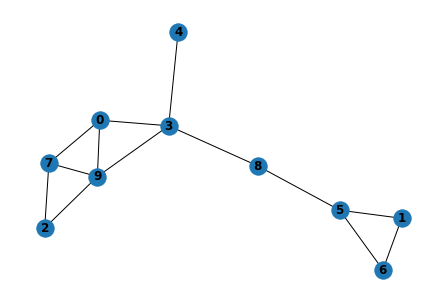

In [3]:
num_nodes = 10
depth = 13
g = gene_graph(num_nodes, 0.3)
print("nodes number: ", len(g.nodes), "nodes: ", g.nodes)
print("edges number: ", len(g.edges), "deges: ", g.edges)
MaxCutG = get_max_cut(g)
print("MaxCut is: ", MaxCutG)
nx.draw(g, with_labels=True, font_weight='bold')

In [4]:
num_qubits = int(np.ceil(len(g.nodes) / 2))
hams = gene_hams(g)
ansatz = gene_ansatz(depth, num_qubits)
print("hams:", hams)
ansatz.svg()

hams: [1 [Z0] , 1 [Z1] , 1 [Z2] , 1 [Z3] , 1 [Z4] , 1 [X0] , 1 [X1] , 1 [X2] , 1 [X3] , 1 [X4] ]


In [5]:
sim = Simulator('projectq', num_qubits)
grad_ops = sim.get_expectation_with_grad(hams, ansatz)
net = MQAnsatzOnlyLayer(grad_ops)

loss_func = MBELoss(g)
optimier = nn.Adam(net.trainable_params(), learning_rate=0.001)
forward_with_loss = ForwardWithLoss(net, loss_func)
train_one_step = TrainOneStep(forward_with_loss, optimier)

In [6]:
max_cut = 0
for i in range(10000):
    train_one_step()
    if (i+1) % 100 == 0:
        logits = net()
        loss = loss_func(logits)
        max_cut = MBEMaxCut(logits, g)
        print("epoch: ", i+1, ", MBE loss: ", loss, ", MBE MaxCut: ", max_cut)
    if int(max_cut) == MaxCutG:
        print("total training step:", i+1)
        break  
if max_cut != MaxCutG and (i+1) == 10000:
    print("Answer Not Found.")

epoch:  100 , MBE loss:  -1.0425489 , MBE MaxCut:  8.0
epoch:  200 , MBE loss:  -1.7133459 , MBE MaxCut:  9.0
epoch:  300 , MBE loss:  -2.2371547 , MBE MaxCut:  9.0
epoch:  400 , MBE loss:  -2.5726838 , MBE MaxCut:  10.0
total training step: 400
